<a href="https://www.kaggle.com/code/lucasrathgeb/xgboost-steel-plate-defects?scriptVersionId=169205530" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faulty-steel-plates/faults.csv
/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


# Importing Libraries

In [2]:
#Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import uniform, randint
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

2024-03-28 19:54:33.215268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 19:54:33.215410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 19:54:33.374449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setup and Importing Data

In [3]:
#Some Settings for testing
validate = False
use_original_data = False
seed = 42

In [4]:
#Import the competition data
train_data = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e3/test.csv")

In [5]:
print(train_data.columns.values)

['id' 'X_Minimum' 'X_Maximum' 'Y_Minimum' 'Y_Maximum' 'Pixels_Areas'
 'X_Perimeter' 'Y_Perimeter' 'Sum_of_Luminosity' 'Minimum_of_Luminosity'
 'Maximum_of_Luminosity' 'Length_of_Conveyer' 'TypeOfSteel_A300'
 'TypeOfSteel_A400' 'Steel_Plate_Thickness' 'Edges_Index' 'Empty_Index'
 'Square_Index' 'Outside_X_Index' 'Edges_X_Index' 'Edges_Y_Index'
 'Outside_Global_Index' 'LogOfAreas' 'Log_X_Index' 'Log_Y_Index'
 'Orientation_Index' 'Luminosity_Index' 'SigmoidOfAreas' 'Pastry'
 'Z_Scratch' 'K_Scatch' 'Stains' 'Dirtiness' 'Bumps' 'Other_Faults']


#### Check for Null Values

In [6]:

null_counts = train_data.isnull().sum()

for column, count in null_counts.items():
    print(f"Column '{column}' has {count} null values")

Column 'id' has 0 null values
Column 'X_Minimum' has 0 null values
Column 'X_Maximum' has 0 null values
Column 'Y_Minimum' has 0 null values
Column 'Y_Maximum' has 0 null values
Column 'Pixels_Areas' has 0 null values
Column 'X_Perimeter' has 0 null values
Column 'Y_Perimeter' has 0 null values
Column 'Sum_of_Luminosity' has 0 null values
Column 'Minimum_of_Luminosity' has 0 null values
Column 'Maximum_of_Luminosity' has 0 null values
Column 'Length_of_Conveyer' has 0 null values
Column 'TypeOfSteel_A300' has 0 null values
Column 'TypeOfSteel_A400' has 0 null values
Column 'Steel_Plate_Thickness' has 0 null values
Column 'Edges_Index' has 0 null values
Column 'Empty_Index' has 0 null values
Column 'Square_Index' has 0 null values
Column 'Outside_X_Index' has 0 null values
Column 'Edges_X_Index' has 0 null values
Column 'Edges_Y_Index' has 0 null values
Column 'Outside_Global_Index' has 0 null values
Column 'LogOfAreas' has 0 null values
Column 'Log_X_Index' has 0 null values
Column 'Lo

There are no null values! So we don't need to remove any samples or do any feature imputation

#### Import the original data for testing

In [7]:
if use_original_data:
    df_org = pd.read_csv("/kaggle/input/faulty-steel-plates/faults.csv")
    print(df_org)

In [8]:
#Preparing the training data

X_train = train_data.copy()

if use_original_data:
    X_train = pd.concat([X_train, df_org],axis=0)
    X_train.reset_index(inplace=True)
print(X_train)

# X_train = X_train[(X_train["TypeOfSteel_A300"]==1) != (X_train["TypeOfSteel_A400"]==1)]
# print(X_train)

target_values = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']

y_train = X_train[target_values]
print(y_train)
X_train = X_train.drop(target_values, axis=1)
if use_original_data:
    X_train = X_train.drop(["id","index"], axis=1)
else:
    X_train = X_train.drop(["id"], axis=1)

print(X_train.columns.values)

          id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0          0        584        590     909972     909977            16   
1          1        808        816     728350     728372           433   
2          2         39        192    2212076    2212144         11388   
3          3        781        789    3353146    3353173           210   
4          4       1540       1560     618457     618502           521   
...      ...        ...        ...        ...        ...           ...   
19214  19214        749        757     143210     143219            17   
19215  19215        723        735    2488529    2488541           231   
19216  19216          6         31    1578055    1578129           780   
19217  19217          9         18    1713172    1713184           126   
19218  19218       1505       1525    1733458    1733471           182   

       X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0                8            5   

In [9]:
X_train.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,128.647380,...,0.030609,0.614749,0.831652,0.591899,2.473475,1.312667,1.389737,0.102742,-0.138382,0.571902
std,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,14.196976,...,0.047302,0.222391,0.220966,0.482050,0.760575,0.467848,0.405549,0.487681,0.120344,0.332219
min,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,39.000000,...,0.001500,0.014400,0.105000,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000
25%,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,124.000000,...,0.006600,0.451600,0.655200,0.000000,1.949400,1.000000,1.079200,-0.272700,-0.192500,0.253200
50%,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,127.000000,...,0.009500,0.636400,0.964300,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142600,0.472900
75%,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,135.000000,...,0.019100,0.785700,1.000000,1.000000,2.814900,1.431400,1.707600,0.529400,-0.084000,0.999400
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,253.000000,...,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000


In [10]:
for target in target_values:
    print(y_train[target].value_counts())

Pastry
0    17753
1     1466
Name: count, dtype: int64
Z_Scratch
0    18069
1     1150
Name: count, dtype: int64
K_Scatch
0    15787
1     3432
Name: count, dtype: int64
Stains
0    18651
1      568
Name: count, dtype: int64
Dirtiness
0    18734
1      485
Name: count, dtype: int64
Bumps
0    14456
1     4763
Name: count, dtype: int64
Other_Faults
0    12661
1     6558
Name: count, dtype: int64


# EDA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

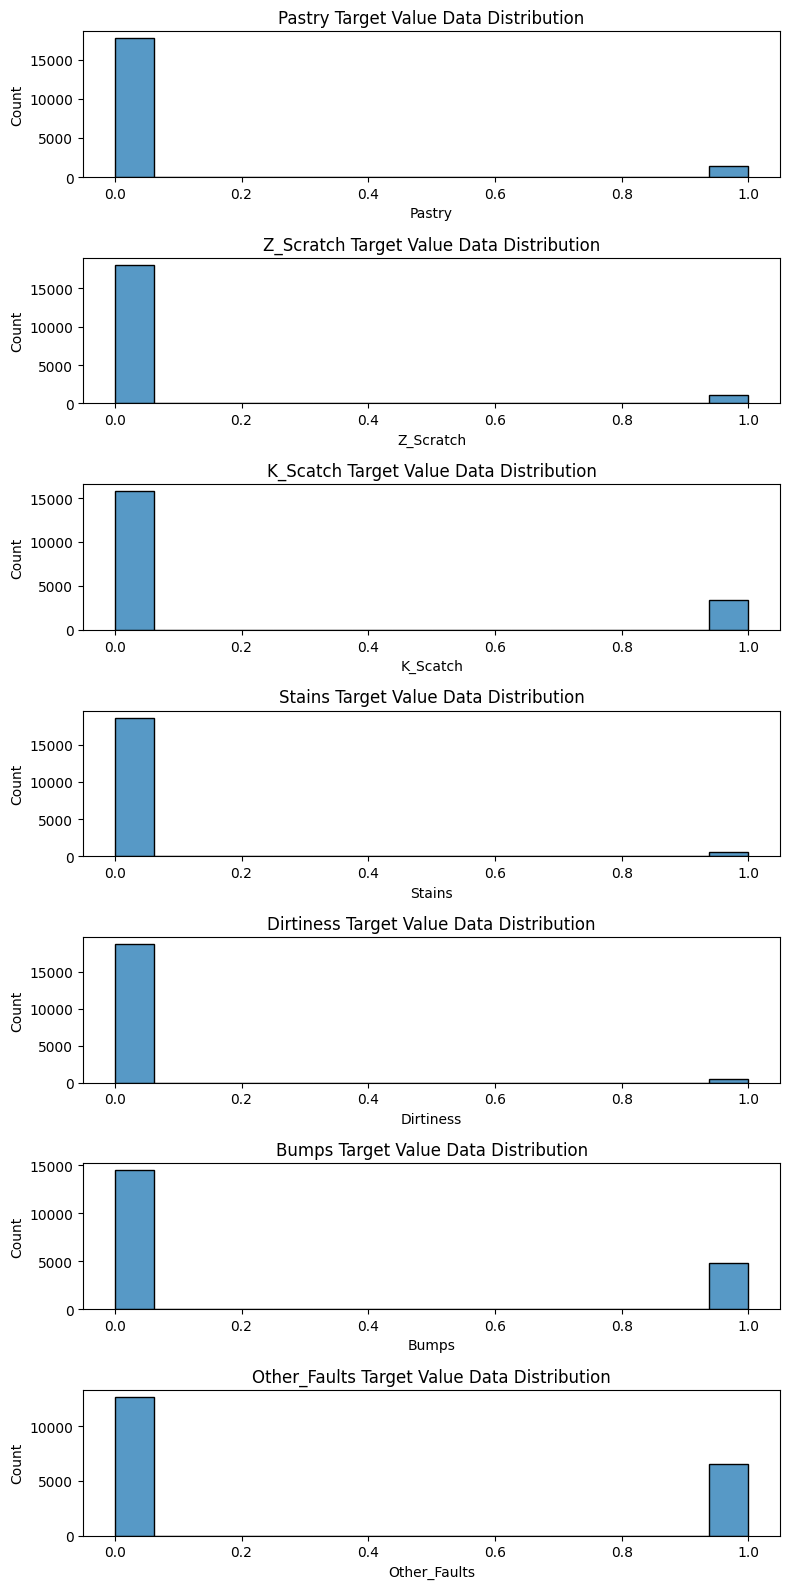

In [11]:
fig, ax = plt.subplots(7, 1, figsize=(8, 16))
for i in range(len(target_values)):
    sns.histplot(x=target_values[i],
                 data=train_data,
                 ax=ax[i])
    ax[i].set_title(f'{target_values[i]} Target Value Data Distribution')
    
plt.tight_layout() 
plt.show()

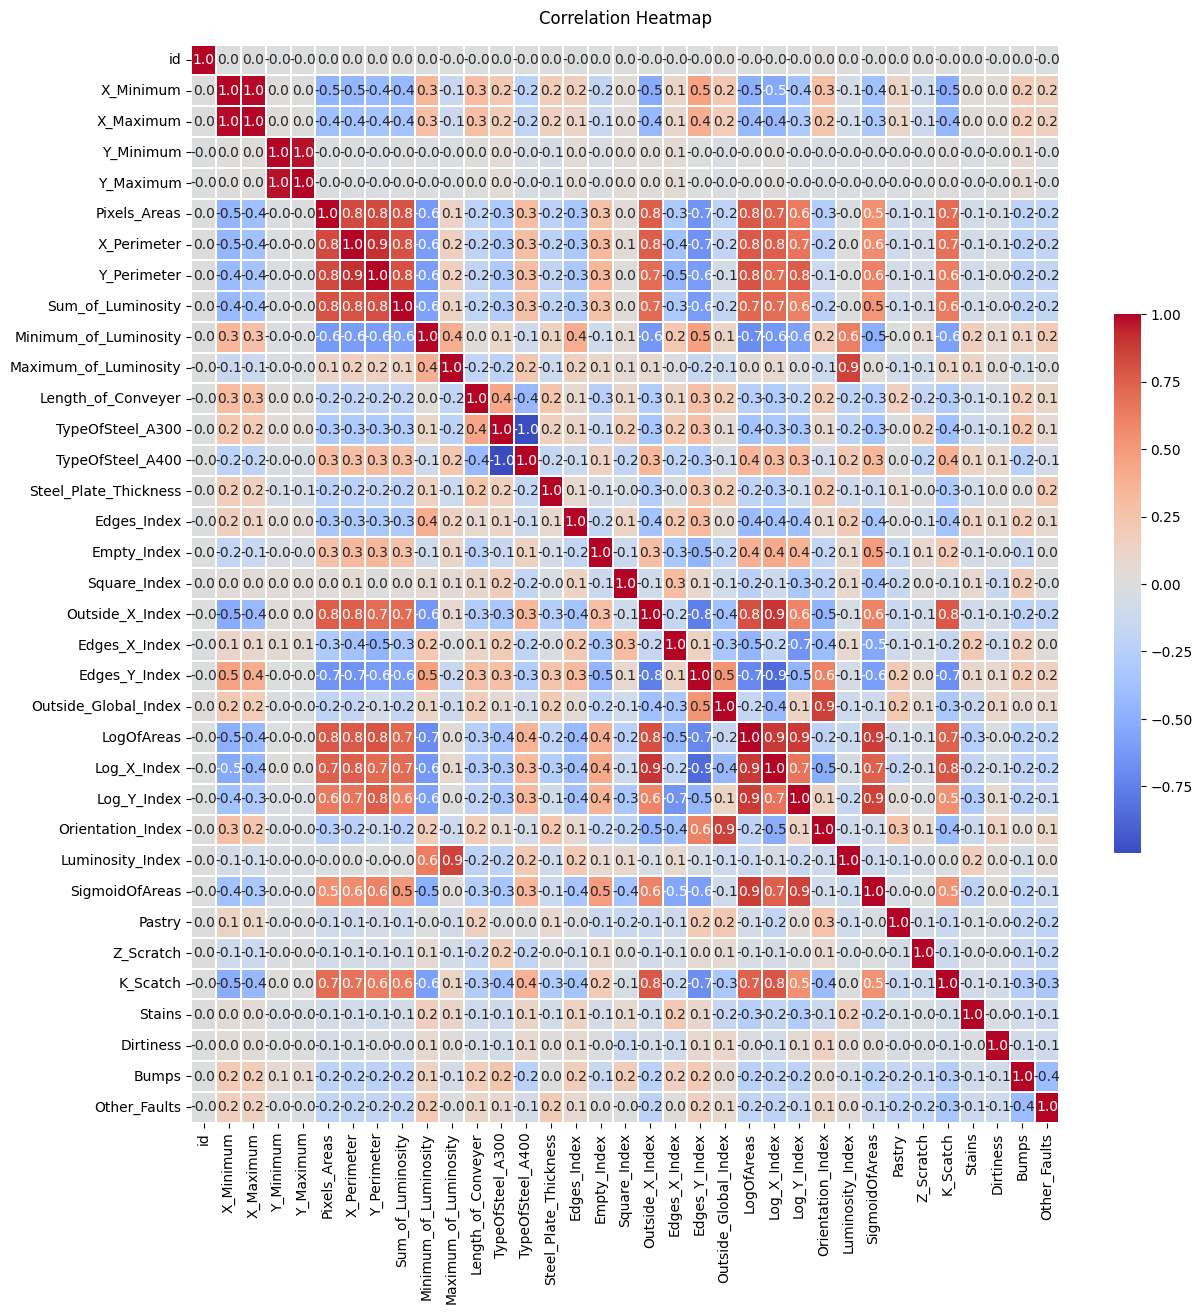

In [12]:
plt.figure(figsize=(14, 14))
heatmap = sns.heatmap(train_data.corr(), annot=True, fmt=".1f", linewidths=.1, cmap='coolwarm', cbar_kws={"shrink": .5})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=15);

{'TypeOfSteel_A400', 'Dirtiness', 'X_Minimum', 'Edges_X_Index', 'K_Scatch', 'Bumps', 'Minimum_of_Luminosity', 'Orientation_Index', 'Empty_Index', 'Edges_Y_Index', 'Outside_X_Index', 'Y_Perimeter', 'Outside_Global_Index', 'Stains', 'Steel_Plate_Thickness', 'SigmoidOfAreas', 'Length_of_Conveyer', 'Maximum_of_Luminosity', 'Pastry', 'TypeOfSteel_A300', 'Z_Scratch', 'Luminosity_Index', 'Other_Faults', 'id', 'X_Perimeter', 'Square_Index', 'X_Maximum', 'Sum_of_Luminosity', 'LogOfAreas', 'Pixels_Areas', 'Log_Y_Index', 'Log_X_Index', 'Edges_Index'}
set()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

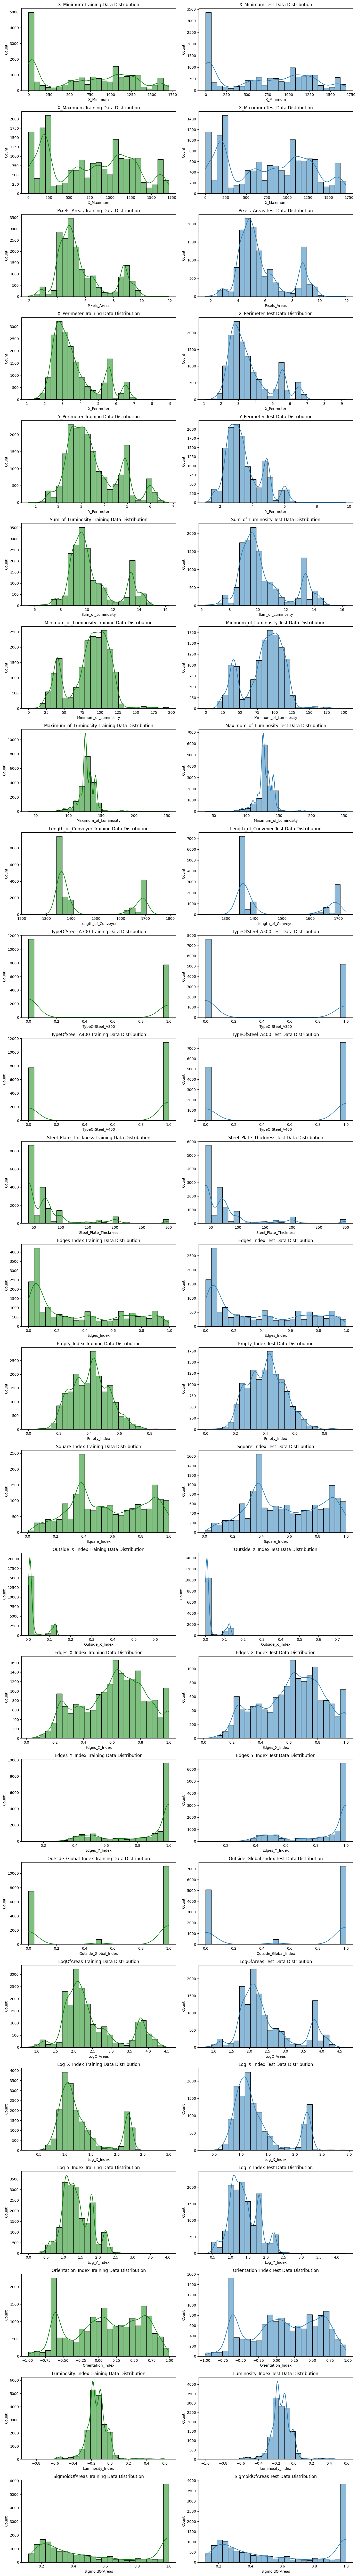

In [13]:
X_train_test = train_data.copy()
X_test_test = test_data.copy()
X_train_test["Pixels_Areas"] = np.log1p(X_train_test["Pixels_Areas"])
X_train_test["X_Perimeter"] = np.log1p(X_train_test["X_Perimeter"])
X_train_test["Y_Perimeter"] = np.log1p(X_train_test["Y_Perimeter"])
X_train_test["Sum_of_Luminosity"] = np.log1p(X_train_test["Sum_of_Luminosity"])

X_train_test = X_train_test.drop(["Y_Maximum", "Y_Minimum"],axis=1)

X_test_test["Pixels_Areas"] = np.log1p(X_test_test["Pixels_Areas"])
X_test_test["X_Perimeter"] = np.log1p(X_test_test["X_Perimeter"])
X_test_test["Y_Perimeter"] = np.log1p(X_test_test["Y_Perimeter"])
X_test_test["Sum_of_Luminosity"] = np.log1p(X_test_test["Sum_of_Luminosity"])

X_test_test = X_test_test.drop(["Y_Maximum", "Y_Minimum"],axis=1)

numeric_cols = set(X_train_test._get_numeric_data().columns.values)
print(numeric_cols)
categorical_cols = set(X_train_test.columns.values) - set(numeric_cols)
print(categorical_cols)

train = X_train_test.copy()
train = train.drop(["id"],axis=1)
train = train.drop(target_values,axis=1)


cols = train.columns.values
# print("id" in numeric_cols)
num_rows = len(cols)
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(14, num_rows*4))

for i in range(num_rows):
    sns.histplot(x=cols[i],
                 data=X_train_test, 
                 bins=25, 
                 color='green', 
                 kde=(cols[i] in numeric_cols),
                 ax=ax[i,0])
    ax[i,0].set_title(f'{cols[i]} Training Data Distribution')

    sns.histplot(x=cols[i], 
                 data=X_test_test, 
                 bins=25, 
                 kde=(cols[i] in numeric_cols), 
                 ax=ax[i,1])
    ax[i,1].set_title(f'{cols[i]} Test Data Distribution')
    
plt.tight_layout() 
plt.show()

In [14]:
print(X_train.columns.values)

['X_Minimum' 'X_Maximum' 'Y_Minimum' 'Y_Maximum' 'Pixels_Areas'
 'X_Perimeter' 'Y_Perimeter' 'Sum_of_Luminosity' 'Minimum_of_Luminosity'
 'Maximum_of_Luminosity' 'Length_of_Conveyer' 'TypeOfSteel_A300'
 'TypeOfSteel_A400' 'Steel_Plate_Thickness' 'Edges_Index' 'Empty_Index'
 'Square_Index' 'Outside_X_Index' 'Edges_X_Index' 'Edges_Y_Index'
 'Outside_Global_Index' 'LogOfAreas' 'Log_X_Index' 'Log_Y_Index'
 'Orientation_Index' 'Luminosity_Index' 'SigmoidOfAreas']


# Feature Engineering

In [15]:
#Feature Engineering for the training set
X_train["Y_Maximum"] = np.sqrt(X_train["Y_Maximum"])
X_train["Y_Minimum"] = np.sqrt(X_train["Y_Minimum"]) 
X_train["Pixels_Areas"] = np.log1p(X_train["Pixels_Areas"])
X_train["X_Perimeter"] = np.log1p(X_train["X_Perimeter"])
X_train["Y_Perimeter"] = np.log1p(X_train["Y_Perimeter"])
X_train["Sum_of_Luminosity"] = np.log1p(X_train["Sum_of_Luminosity"])

X_train = X_train.drop(["TypeOfSteel_A400"], axis=1)
print(X_train)

       X_Minimum  X_Maximum    Y_Minimum    Y_Maximum  Pixels_Areas  \
0            584        590   953.924525   953.927146      2.833213   
1            808        816   853.434239   853.447128      6.073045   
2             39        192  1487.304945  1487.327805      9.340403   
3            781        789  1831.159742  1831.167114      5.351858   
4           1540       1560   786.420371   786.448981      6.257668   
...          ...        ...          ...          ...           ...   
19214        749        757   378.430971   378.442862      2.890372   
19215        723        735  1577.507211  1577.511014      5.446737   
19216          6         31  1256.206591  1256.236045      6.660575   
19217          9         18  1308.881966  1308.886550      4.844187   
19218       1505       1525  1316.608522  1316.613459      5.209486   

       X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0         2.197225     1.791759           7.729735                    

In [16]:
if validate == True:
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

# Recursive Feature Elimination with Cross-Validation

In [17]:
## Recursive feature elimination with cross-validation to select features.
# cv = KFold(n_splits = 5)
# model_features = []
# for target in target_values:
#     estimator = XGBClassifier(eval_metric='auc', random_state=seed)
#     rfe = RFECV(estimator=estimator, cv=cv, scoring='roc_auc')
#     rfe.fit(X_train, y_train[target])
#     print("For Target: " + target)
#     print("Optimal number of features: %d" % rfe.n_features_)
#     print('Selected features: %s' % list(X_train.columns[rfe.support_]))
#     print("")
#     model_features.append(list(X_train.columns[rfe.support_]))
    
# print(model_features)

# feature_dict = dict(zip(target_values, model_features))
# print(feature_dict)

In [18]:
# # Best features from RFECV 
model_features =[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas'],
                ['X_Minimum', 'X_Maximum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Outside_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas'],
                ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas'],
                ['X_Minimum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas'],
                ['X_Minimum', 'X_Maximum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas'],
                ['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Minimum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'Steel_Plate_Thickness', 'Edges_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index'],
                ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']]

feature_dict = dict(zip(target_values, model_features))
# print(feature_dict)

# Hyperparameter Tuning

In [19]:
# hyper_params = dict()

## params and ranges to search
# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 3),
#     "learning_rate": uniform(0.02, 0.3), # default 0.1 
#     "max_depth": randint(3, 8), # default 3
#     "n_estimators": randint(75, 1100), # default 100
#     "subsample": uniform(0.6, 0.4),
#     "scale_pos_weight": uniform(0.7,25)
    
# }
## perform hyperparameter searching specific to each target value and determine the best hyperparams for each model
# for target in target_values:
#     xgb_model = XGBClassifier(eval_metric='auc', random_state=seed)
#     search = RandomizedSearchCV(xgb_model, 
#                                 param_distributions=params, 
#                                 random_state=seed, 
#                                 n_iter=500, 
#                                 cv=4, 
#                                 verbose=1, 
#                                 n_jobs=1, 
#                                 return_train_score=True,
#                                 scoring= 'roc_auc',
#                                 )
#     search.fit(X_train[feature_dict[target]], y_train[target])
#     print("Best Params For Target: " + target)
#     print(search.best_estimator_)
#     print(search.best_score_)
#     print(search.best_params_)
#     print("")
    
#     hyper_params.update({target:search.best_params_})

In [20]:
# print(search.cv_results_)

#### Best Hyperparameters Found

In [21]:
# #best hyper params found for each model using data transformations (log1p and sqrt), model RFECV feature selection,
# #v28 
# hyper_params = {
#     "Pastry":{'colsample_bytree': 0.8915509098941256, 'gamma': 2.9656421146582415, 'learning_rate': 0.057635216528601665, 'max_depth': 4, 'n_estimators': 159, 'subsample': 0.766572807122957},
#     "Z_Scratch":{'colsample_bytree': 0.820082560697887, 'gamma': 0.19662029230273648, 'learning_rate': 0.036159638223812844, 'max_depth': 3, 'n_estimators': 406, 'subsample': 0.9580283476084945},
#     "K_Scatch":{'colsample_bytree': 0.820082560697887, 'gamma': 0.19662029230273648, 'learning_rate': 0.036159638223812844, 'max_depth': 3, 'n_estimators': 406, 'subsample': 0.9580283476084945},
#     "Stains":{'colsample_bytree': 0.755869940132982, 'gamma': 0.7134635131055546, 'learning_rate': 0.09763611024902183, 'max_depth': 6, 'n_estimators': 409, 'subsample': 0.8503334162653615},
#     "Dirtiness":{'colsample_bytree': 0.8045904128281929, 'gamma': 2.213014921266445, 'learning_rate': 0.03809702049991895, 'max_depth': 6, 'n_estimators': 412, 'subsample': 0.8758717333829716},
#     "Bumps":{'colsample_bytree': 0.8412453913241366, 'gamma': 1.7194094966626894, 'learning_rate': 0.08826360631048044, 'max_depth': 3, 'n_estimators': 217, 'subsample': 0.9233411206520182},
#     "Other_Faults":{'colsample_bytree': 0.820082560697887, 'gamma': 0.19662029230273648, 'learning_rate': 0.036159638223812844, 'max_depth': 3, 'n_estimators': 406, 'subsample': 0.9580283476084945},
# }

In [22]:
# # cv = 5
# # 1000 fits
# hyper_params={
#     "Pastry":{'colsample_bytree': 0.7131008040490312, 'gamma': 3.016577763944733, 'learning_rate': 0.030286649844187434, 'max_depth': 3, 'n_estimators': 793, 'subsample': 0.9123024358474074},
#     "Z_Scratch":{'colsample_bytree': 0.6066508689073757, 'gamma': 2.1798348637193774, 'learning_rate': 0.05208034253252845, 'max_depth': 4, 'n_estimators': 281, 'subsample': 0.9657792298445707},
#     "K_Scatch":{'colsample_bytree': 0.6133985143853005, 'gamma': 0.267554065324887, 'learning_rate': 0.021723384267255653, 'max_depth': 6, 'n_estimators': 334, 'subsample': 0.6325597285021936},
#     "Stains":{'colsample_bytree': 0.6599505551566636, 'gamma': 0.783980719168802, 'learning_rate': 0.05027507974590953, 'max_depth': 7, 'n_estimators': 561, 'subsample': 0.8994255638604864},
#     "Dirtiness":{'colsample_bytree': 0.6133985143853005, 'gamma': 0.267554065324887, 'learning_rate': 0.021723384267255653, 'max_depth': 6, 'n_estimators': 334, 'subsample': 0.6325597285021936},
#     "Bumps":{'colsample_bytree': 0.7175096070701459, 'gamma': 4.337393243660427, 'learning_rate': 0.012404691108684, 'max_depth': 7, 'n_estimators': 1122, 'subsample': 0.6835535416623714},
#     "Other_Faults":{'colsample_bytree': 0.918185387985943, 'gamma': 2.379862867540146, 'learning_rate': 0.011793970983282597, 'max_depth': 4, 'n_estimators': 638, 'subsample': 0.7892088582480716}
# }

In [23]:
# cv = 5
# added scale_pos_weight parameter
# 2000 fits
hyper_params={
    "Pastry":{'colsample_bytree': 0.7821369415164092, 'gamma': 2.632896974642649, 'learning_rate': 0.035002251667449996, 'max_depth': 3, 'n_estimators': 475, 'scale_pos_weight': 4.195574861914315, 'subsample': 0.6108689519921294},
    "Z_Scratch":{'colsample_bytree': 0.664133427588007, 'gamma': 1.4709212064823562, 'learning_rate': 0.028874218410994308, 'max_depth': 3, 'n_estimators': 476, 'scale_pos_weight': 4.369164212165561, 'subsample': 0.8552760271587161},
    "K_Scatch":{'colsample_bytree': 0.6014645383095847, 'gamma': 1.2492546542738392, 'learning_rate': 0.055486643416493585, 'max_depth': 3, 'n_estimators': 381, 'scale_pos_weight': 5.726856243481793, 'subsample': 0.7155772293559524},
    "Stains":{'colsample_bytree': 0.6494856296870699, 'gamma': 2.1648422825553353, 'learning_rate': 0.12436057068854348, 'max_depth': 6, 'n_estimators': 1035, 'scale_pos_weight': 18.299679493348556, 'subsample': 0.9603136058298485},
    "Dirtiness":{'colsample_bytree': 0.6157838404307602, 'gamma': 2.247474299360974, 'learning_rate': 0.018500252451450663, 'max_depth': 6, 'n_estimators': 817, 'scale_pos_weight': 1.6735769215297136, 'subsample': 0.920539268580794},
    "Bumps":{'colsample_bytree': 0.8341492769799272, 'gamma': 1.2980608279942363, 'learning_rate': 0.06345156774671998, 'max_depth': 4, 'n_estimators': 563, 'scale_pos_weight': 0.17103666227019856, 'subsample': 0.7419562966681374},
    "Other_Faults":{'colsample_bytree': 0.7287733763769197, 'gamma': 2.8180989839563706, 'learning_rate': 0.01133181604993617, 'max_depth': 5, 'n_estimators': 365, 'scale_pos_weight': 0.5772735317094212, 'subsample': 0.8239770394615282}
}


# Model Training

In [24]:
train_preds = pd.DataFrame()
models = []
for target in target_values:
    
    model = XGBClassifier(eval_metric='auc',
                          random_state=seed,
                          **hyper_params[target])
    model.fit(X_train[feature_dict[target]], y_train[target])
    models.append(model)
    predictions = pd.DataFrame(model.predict_proba(X_train[feature_dict[target]]))[1]
    train_preds[target] = predictions

print(train_preds)
print(y_train)

         Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0      0.005287   0.002720  0.006290  0.980029   0.002558  0.003307   
1      0.756123   0.000960  0.000720  0.000050   0.003724  0.054201   
2      0.001781   0.001094  0.984846  0.000088   0.000349  0.000472   
3      0.220938   0.006970  0.492102  0.001084   0.102068  0.017863   
4      0.403059   0.006538  0.007973  0.000102   0.016555  0.011489   
...         ...        ...       ...       ...        ...       ...   
19214  0.012216   0.002233  0.002194  0.982767   0.004350  0.002281   
19215  0.138336   0.012664  0.000726  0.000179   0.030509  0.048844   
19216  0.364035   0.062140  0.074650  0.000033   0.009405  0.017399   
19217  0.553618   0.011925  0.000135  0.000381   0.027509  0.059429   
19218  0.545463   0.009774  0.001182  0.000204   0.007161  0.101691   

       Other_Faults  
0          0.133139  
1          0.267126  
2          0.046376  
3          0.359177  
4          0.532914  
...            

# Model Validation

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

if validate == True:
    val_preds = pd.DataFrame()
    for i in range(len(models)):
        
        predictions = pd.DataFrame(models[i].predict_proba(X_valid[model_features[i]]))[1]
        val_preds[target_values[i]] = predictions

    print(val_preds)
    print(y_valid)

In [26]:
avg_roc = 0
if validate == True:
    for target in target_values:
        print("ROC Validation Score for " + target + ": ", roc_auc_score(y_valid[target], val_preds[target]))
        avg_roc += roc_auc_score(y_valid[target], val_preds[target])
avg_roc = avg_roc / len(target_values)
print("Average ROC Val Score: " + str(avg_roc))

Average ROC Val Score: 0.0


Seed 10: Average ROC Val Score: 0.8892620780807298<br>
Seed 256: Average ROC Val Score: 0.8912339470027113

0.6, 0.2
ROC Validation Score for Other_Faults:  0.7002577047510822

with orig data, 0.2, 0.4
ROC Validation Score for Other_Faults:  0.7210378053074682

ROC Validation Score for Pastry:  0.8741660683445559<br>
ROC Validation Score for Z_Scratch:  0.9588163252394059<br>
ROC Validation Score for K_Scatch:  0.9868087941372419<br>
ROC Validation Score for Stains:  0.9873504273504273<br>
ROC Validation Score for Dirtiness:  0.8924471037114118<br>
ROC Validation Score for Bumps:  0.8129076142446523<br>
ROC Validation Score for Other_Faults:  0.6949694790638176<br>

# Testing

In [27]:
X_test = test_data.copy()
X_test = X_test.drop("id", axis=1)
print(X_test.columns.values)

['X_Minimum' 'X_Maximum' 'Y_Minimum' 'Y_Maximum' 'Pixels_Areas'
 'X_Perimeter' 'Y_Perimeter' 'Sum_of_Luminosity' 'Minimum_of_Luminosity'
 'Maximum_of_Luminosity' 'Length_of_Conveyer' 'TypeOfSteel_A300'
 'TypeOfSteel_A400' 'Steel_Plate_Thickness' 'Edges_Index' 'Empty_Index'
 'Square_Index' 'Outside_X_Index' 'Edges_X_Index' 'Edges_Y_Index'
 'Outside_Global_Index' 'LogOfAreas' 'Log_X_Index' 'Log_Y_Index'
 'Orientation_Index' 'Luminosity_Index' 'SigmoidOfAreas']


#### Preparing Test Data Features

In [28]:
X_test["Pixels_Areas"] = np.log1p(X_test["Pixels_Areas"])
X_test["X_Perimeter"] = np.log1p(X_test["X_Perimeter"])
X_test["Y_Perimeter"] = np.log1p(X_test["Y_Perimeter"])
X_test["Sum_of_Luminosity"] = np.log1p(X_test["Sum_of_Luminosity"])

X_test["Y_Maximum"] = np.sqrt(X_test["Y_Maximum"])
X_test["Y_Minimum"] = np.sqrt(X_test["Y_Minimum"])

X_test = X_test.drop(["TypeOfSteel_A400"], axis=1)

print(X_test)

       X_Minimum  X_Maximum    Y_Minimum    Y_Maximum  Pixels_Areas  \
0           1015       1033  1956.160525  1956.166660      6.492240   
1           1257       1271   648.043208   648.053239      5.916202   
2           1358       1372   343.096196   343.109312      5.669881   
3            158        168   482.094389   482.120317      4.394449   
4            559        592   737.817728   737.827216      4.948760   
...          ...        ...          ...          ...           ...   
12809       1101       1116   669.285440   669.322045      5.749393   
12810       1289       1306  1774.681380  1774.694903      4.094345   
12811         41        210  1259.974206  1259.837688      9.716254   
12812       1329       1340   837.995823   838.013723      5.958425   
12813         39        187  1363.677381  1363.683614      8.609043   

       X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0         3.178054     3.850148          11.040647                    

# Predictions

In [29]:
preds = pd.DataFrame()
for i in range(len(models)):
    
    predictions = pd.DataFrame(models[i].predict_proba(X_test[model_features[i]]))[1]
    preds[target_values[i]] = predictions
    
print(preds)

         Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0      0.813814   0.004109  0.009092  0.000065   0.021010  0.037633   
1      0.510965   0.059303  0.013052  0.000178   0.211047  0.032398   
2      0.003705   0.199911  0.128799  0.000249   0.004428  0.092588   
3      0.458013   0.002279  0.000520  0.000239   0.010201  0.092686   
4      0.004108   0.003591  0.002374  0.001261   0.007031  0.194457   
...         ...        ...       ...       ...        ...       ...   
12809  0.144200   0.274555  0.003843  0.000120   0.030719  0.029417   
12810  0.467342   0.009575  0.039559  0.002111   0.193165  0.031499   
12811  0.001062   0.001061  0.988755  0.000088   0.000416  0.000472   
12812  0.736996   0.031365  0.028111  0.000153   0.073147  0.036187   
12813  0.004254   0.009272  0.980580  0.000086   0.000418  0.000601   

       Other_Faults  
0          0.225818  
1          0.235220  
2          0.342887  
3          0.304285  
4          0.267676  
...            

# Submission

In [30]:
submission = pd.DataFrame()
submission["id"] = test_data["id"]
submission = pd.concat([submission, preds],axis=1)

print(submission)
submission.to_csv('submission.csv',index=False)
submission.describe()

          id    Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0      19219  0.813814   0.004109  0.009092  0.000065   0.021010  0.037633   
1      19220  0.510965   0.059303  0.013052  0.000178   0.211047  0.032398   
2      19221  0.003705   0.199911  0.128799  0.000249   0.004428  0.092588   
3      19222  0.458013   0.002279  0.000520  0.000239   0.010201  0.092686   
4      19223  0.004108   0.003591  0.002374  0.001261   0.007031  0.194457   
...      ...       ...        ...       ...       ...        ...       ...   
12809  32028  0.144200   0.274555  0.003843  0.000120   0.030719  0.029417   
12810  32029  0.467342   0.009575  0.039559  0.002111   0.193165  0.031499   
12811  32030  0.001062   0.001061  0.988755  0.000088   0.000416  0.000472   
12812  32031  0.736996   0.031365  0.028111  0.000153   0.073147  0.036187   
12813  32032  0.004254   0.009272  0.980580  0.000086   0.000418  0.000601   

       Other_Faults  
0          0.225818  
1          0.235220

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000
mean,25625.500000,0.184075,0.108627,0.221550,0.037664,0.029414,0.071667,0.242085
std,3699.227509,0.224482,0.222633,0.372570,0.178226,0.076950,0.076877,0.124521
min,19219.000000,0.000426,0.000105,0.000052,0.000024,0.000237,0.000472,0.030431
25%,22422.250000,0.004692,0.003045,0.001318,0.000100,0.002373,0.014664,0.174708
50%,25625.500000,0.069204,0.014163,0.007324,0.000200,0.007012,0.048516,0.244253
75%,28828.750000,0.319969,0.076899,0.213415,0.000628,0.021641,0.101656,0.310825
max,32032.000000,0.930155,0.981672,0.994541,0.994831,0.841115,0.518484,0.740639
